In [166]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score,precision_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [167]:
df = pd.read_csv('phishing_data_by_type.csv',index_col=False)
df

Subject  \
0           URGENT BUSINESS ASSISTANCE AND PARTNERSHIP   
1                  URGENT ASSISTANCE /RELATIONSHIP (P)   
2                                      GOOD DAY TO YOU   
3                                     from Mrs.Johnson   
4                                         Co-Operation   
..                                                 ...   
154                 These Bags Just Arrived For Spring   
155  POTUS Comes to Broadway this April! Get Ticket...   
156                       Let’s talk about Bridgerton!   
157                    MONDAY MIX: All eyes on Ukraine   
158  The DOTD is back on with 15% off a lightning-f...   

                                                  Text             Type  
0    URGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\...            Fraud  
1    Dear Friend,\n\nI am Mr. Ben Suleman a custom ...            Fraud  
2    FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...            Fraud  
3    Goodday Dear\n\n\nI know this mail will come t...            Fraud  
4    FROM MR. GODWIN AKWESI\nTEL: +233 208216645\nF...            Fraud  
..                                                 ...              ...  
154  Bags so perfect—you'll never want to be withou...  Commercial Spam  
155  INAUGURAL BROADWAY PERFORMANCE APRIL 14\r\nA N...  Commercial Spam  
156  GET THE BEST OF EVERYTHING IN THE APP\n\nSTARB...  Commercial Spam  
157  Hi!\n \nSpring forward with our newest noPac c...  Commercial Spam  
158  Hi,  | PLAYER MEMBER | 0 Points\n\nEarn And Sa...  Commercial Spam  

[159 rows x 3 columns]

# Data Cleanning

In [168]:
df.shape

(159, 3)

In [169]:
# missing values
df.isnull().sum()

Subject    2
Text       0
Type       0
dtype: int64

In [170]:
# check for duplicate values
df.duplicated().sum()

0

In [171]:
df.describe()

Subject  \
count                                          157   
unique                                         157   
top     URGENT BUSINESS ASSISTANCE AND PARTNERSHIP   
freq                                             1   

                                                     Text   Type  
count                                                 159    159  
unique                                                159      4  
top     URGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\...  Fraud  
freq                                                    1     40

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  157 non-null    object
 1   Text     159 non-null    object
 2   Type     159 non-null    object
dtypes: object(3)
memory usage: 3.9+ KB


In [173]:
# drop subject column 
df.drop(columns=['Subject'],inplace=True)

In [174]:
#renaming the columns 
df.rename(columns={'Type':'Target'},inplace=True)
df.sample(5)

Text           Target
12   20 SILVER CRESCENT,\nEnugu,Nigeria.\n\nComplim...            Fraud
147  eyebuydirect\nEYEGLASSES SUNGLASSES PREMIUM BR...  Commercial Spam
131  \nYou can still give sleep’s lovely gift to yo...  Commercial Spam
136  View email in your browser.\n23andMe\nOUR WAY ...  Commercial Spam
61   CONGRATULATION\n \n\n \nYou’ve Won,\n \nPlease...         Phishing

In [175]:
#Dropping rows with unrelated target values to this study 
df = df[~df["Target"].isin(["Commercial Spam", "Fraud"])] 
df.sample(5)

Text            Target
91   I’m running about 30 minutes late but I will b...  False Positives 
114  Email Notice to Students\nSubject:  Notice of ...  False Positives 
85   Happy Sunday everyone!\r\n\r\nWanted to take a...  False Positives 
81   Hello!\r\n\r\nYou are receiving this email bec...  False Positives 
115  Your lab results are now available on our pati...  False Positives

In [176]:
#renaming false positive values to email label 
df['Target'] = df['Target'].replace({'False Positives ': 'Email'})
df.sample(5)

C:\Users\Acer\AppData\Local\Temp\ipykernel_53168\3972835177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = df['Target'].replace({'False Positives ': 'Email'})


Text    Target
88  Part 2 of the inner core - YFSCAWA :) - series...     Email
72  (1) Unclaimed Asset Notification For:\n\nDATE\...  Phishing
98  Hi,\n\nYou’ll be presenting to the class, the ...     Email
69  ALL LAWN PLANS\r\n50%OFF◇ first application\r\...  Phishing
81  Hello!\r\n\r\nYou are receiving this email bec...     Email

In [177]:
phishing_cleaned = df.to_csv('CleanedPhishing.csv', index=False)

# load cleanned dataset

In [178]:
df = pd.read_csv('CleanedPhishing.csv',index_col=False)
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.head(5))

Text      0
Target    0
dtype: int64
0
                                                Text    Target
0  PayPal is committed to maintaining a safe envi...  Phishing
1  R0lGODlhYAJpAfPkAAQIAKbK8ICAgABgwACAwCCAwECAwE...  Phishing
2  Dear eBay User ,\n\nAfter fraud complaints fro...  Phishing
3  This notice informs you that your Credit Union...  Phishing
4  lobe hank, tap catchon plan, note phew jinx un...  Phishing


# Encoding

In [179]:
#converting categorical labels into numerical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])

# EDA

In [180]:
df['Target'].value_counts()

Target
1    40
0    39
Name: count, dtype: int64

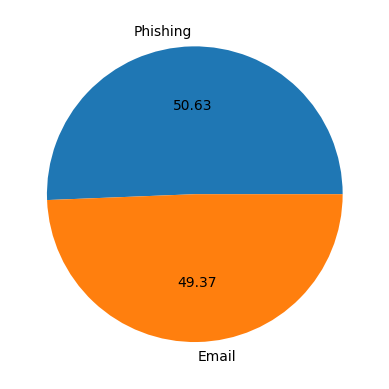

In [181]:
df['Target'].value_counts()
plt.pie(df['Target'].value_counts(), labels=['Phishing','Email'],autopct="%0.2f")
plt.show()

# Data Transformation

In [182]:
import nltk

# Download the 'punkt_tab' data package
nltk.download('punkt_tab')

# Now you can use word_tokenize and sent_tokenize
df['num_characters'] = df['Text'].apply(len)
df['num_words'] = df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Text  Target  num_characters  \
0  PayPal is committed to maintaining a safe envi...       1            1450   
1  R0lGODlhYAJpAfPkAAQIAKbK8ICAgABgwACAwCCAwECAwE...       1            9957   
2  Dear eBay User ,\n\nAfter fraud complaints fro...       1            1306   
3  This notice informs you that your Credit Union...       1            1053   
4  lobe hank, tap catchon plan, note phew jinx un...       1            1700   

   num_words  num_sentences  
0        304              9  
1        122              1  
2        305              6  
3        223              8  
4        298              2

In [183]:
df['num_characters'] = df['Text'].apply(len)
df['num_words'] = df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

Text  Target  num_characters  \
0  PayPal is committed to maintaining a safe envi...       1            1450   
1  R0lGODlhYAJpAfPkAAQIAKbK8ICAgABgwACAwCCAwECAwE...       1            9957   
2  Dear eBay User ,\n\nAfter fraud complaints fro...       1            1306   
3  This notice informs you that your Credit Union...       1            1053   
4  lobe hank, tap catchon plan, note phew jinx un...       1            1700   

   num_words  num_sentences  
0        304              9  
1        122              1  
2        305              6  
3        223              8  
4        298              2

In [184]:
df[['num_characters','num_words','num_sentences']].describe()

num_characters    num_words  num_sentences
count       79.000000    79.000000      79.000000
mean      1447.531646   248.367089      10.227848
std       2420.591466   413.178709      17.500146
min         29.000000     6.000000       1.000000
25%        375.000000    73.000000       3.000000
50%        862.000000   137.000000       6.000000
75%       1503.500000   287.500000      11.000000
max      18282.000000  3375.000000     140.000000

In [185]:
#Emails
df[df['Target'] == 0][['num_characters','num_words','num_sentences']].describe()

num_characters   num_words  num_sentences
count       39.000000   39.000000      39.000000
mean      1267.025641  230.205128      11.589744
std       1287.887775  234.700501      12.012533
min         65.000000   16.000000       2.000000
25%        387.500000   77.000000       5.000000
50%        981.000000  162.000000       9.000000
75%       1503.500000  262.000000      11.500000
max       5338.000000  914.000000      63.000000

In [186]:
#Phishing
df[df['Target'] == 1][['num_characters','num_words','num_sentences']].describe()

num_characters    num_words  num_sentences
count       40.000000    40.000000      40.000000
mean      1623.525000   266.075000       8.900000
std       3168.288262   535.826387      21.638996
min         29.000000     6.000000       1.000000
25%        369.000000    64.250000       2.750000
50%        632.000000   118.500000       4.000000
75%       1476.500000   299.500000       8.000000
max      18282.000000  3375.000000     140.000000

<Axes: xlabel='num_characters', ylabel='Count'>

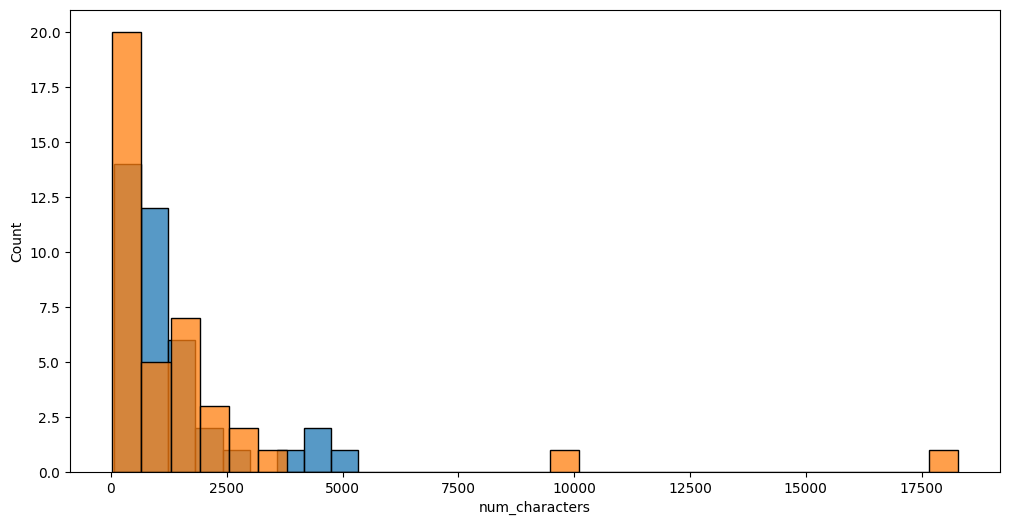

In [187]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Target'] == 0]['num_characters'])
sns.histplot(df[df['Target'] == 1]['num_characters'])

<Axes: xlabel='num_words', ylabel='Count'>

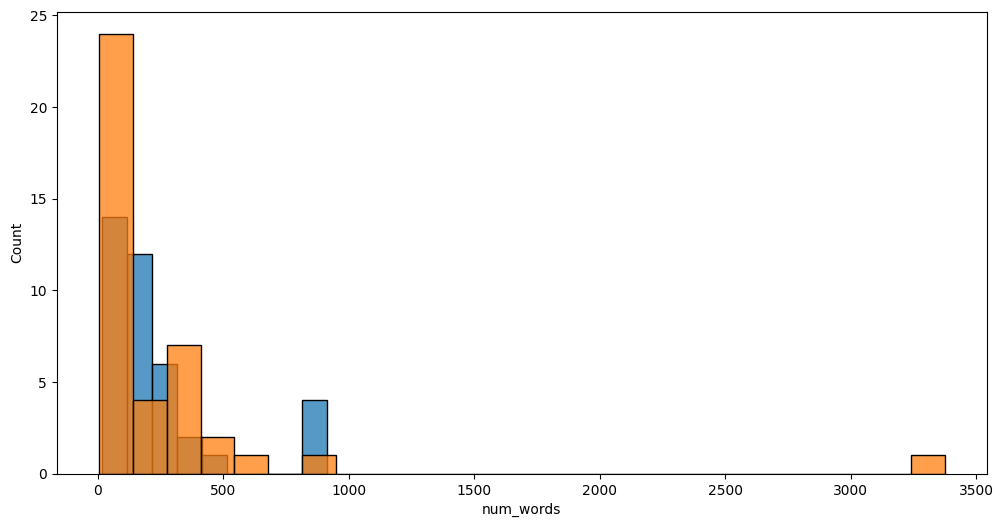

In [188]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Target'] == 0]['num_words'])
sns.histplot(df[df['Target'] == 1]['num_words'])

<Axes: xlabel='num_sentences', ylabel='Count'>

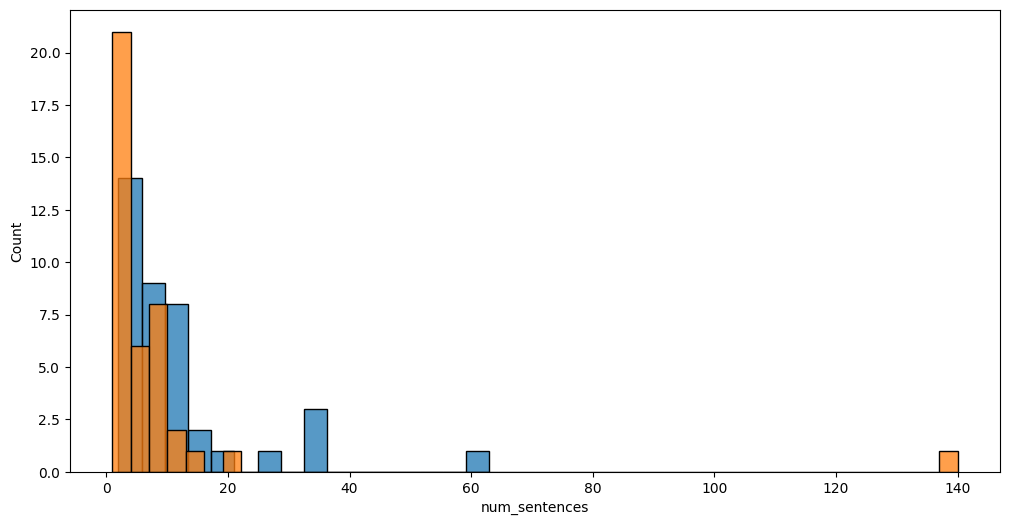

In [189]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Target'] == 0]['num_sentences'])
sns.histplot(df[df['Target'] == 1]['num_sentences'])

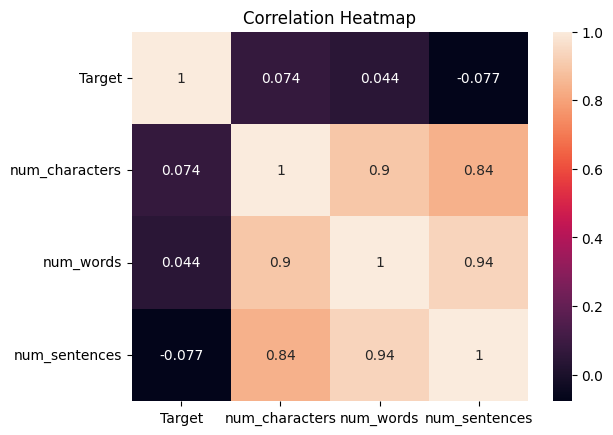

In [190]:
subset_df = df[['Target','num_characters','num_words','num_sentences']]
corr_matrix = subset_df.corr()
sns.heatmap(corr_matrix,annot=True)
plt.title('Correlation Heatmap')
plt.show()

# Text Preprocessing

function performs lowercasing, tokenization, removal of special characters, removal of stop words and punctuation, stemming, and finally returns the preprocessed text as a string

In [191]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [192]:
import string
from nltk.stem import PorterStemmer
ps = PorterStemmer()


In [193]:

def transform_text(text):
    text = text.lower()  # lower casting
    text = nltk.word_tokenize(text)  # tokenizing
    
    y = []
    for i in text: # removing special characters % 
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:    #stop words and string punctuation
        if i not in stopwords.words('english') and i not in string.punctuation: 
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [194]:
from nltk.corpus import stopwords
transform_text("Take Control of Your Debt Today Complete The From Below To Get Financial HelpGET STARTED        ?Can't Load Image? CLICK HERE To See it! If you do not wish to continue receiving email newsletters CLICK HERE")

'take control debt today complet get financi helpget start ca load imag click see wish continu receiv email newslett click'

In [195]:
df['transformed_text'] = df['Text'].apply(transform_text)
df.head()

Text  Target  num_characters  \
0  PayPal is committed to maintaining a safe envi...       1            1450   
1  R0lGODlhYAJpAfPkAAQIAKbK8ICAgABgwACAwCCAwECAwE...       1            9957   
2  Dear eBay User ,\n\nAfter fraud complaints fro...       1            1306   
3  This notice informs you that your Credit Union...       1            1053   
4  lobe hank, tap catchon plan, note phew jinx un...       1            1700   

   num_words  num_sentences                                   transformed_text  
0        304              9  paypal commit maintain safe environ commun buy...  
1        122              1  iyp9bywoj5apdxcebaugcqtfc2mdaraeoakhuwmlp6cika...  
2        305              6  dear ebay user fraud complaint ebay member eba...  
3        223              8  notic inform credit union bank join ou r feder...  
4        298              2  lobe hank tap catchon plan note phew jinx unit...

In [196]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [197]:
! pip install wordcloud


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


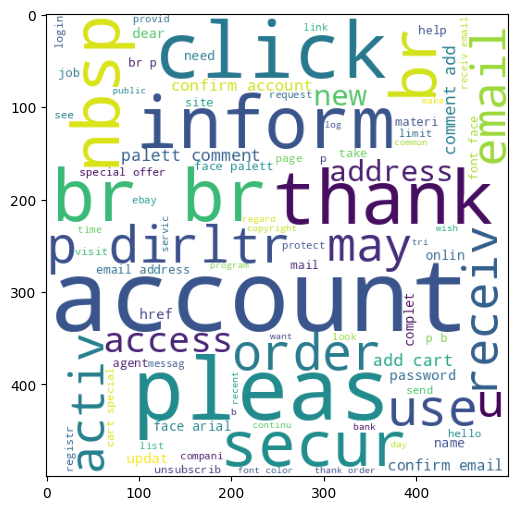

In [198]:
phishing_wc = wc.generate(df[df['Target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(phishing_wc)

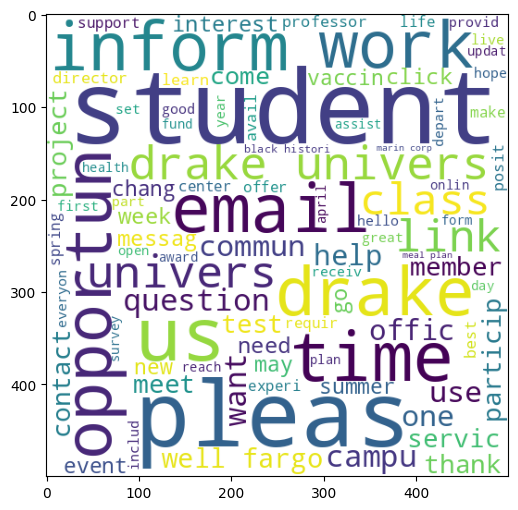

In [199]:
email_wc = wc.generate(df[df['Target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(email_wc)

In [200]:
phishing_corpus = []
for msg in df[df['Target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        phishing_corpus.append(word)
len(phishing_corpus)

4893

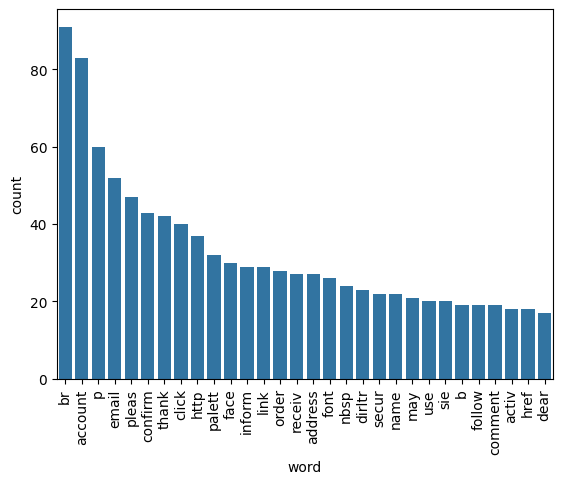

In [201]:

from collections import Counter

data = pd.DataFrame(Counter(phishing_corpus).most_common(30), columns=['word', 'count'])
sns.barplot(x='word', y='count', data=data)
plt.xticks(rotation='vertical')
plt.show()

In [202]:
email_corpus = []
for msg in df[df['Target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        email_corpus.append(word)
len(email_corpus)

4189

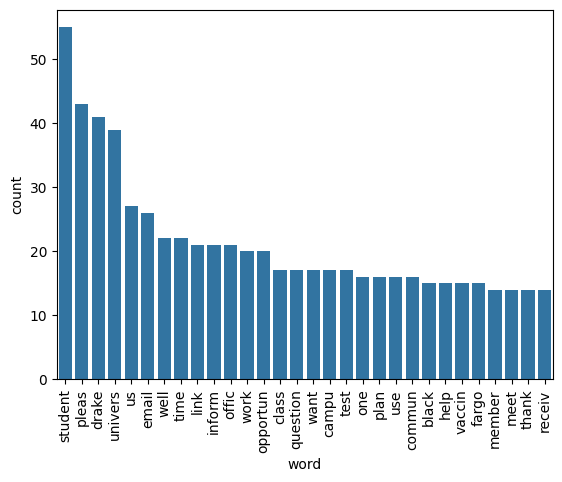

In [203]:
data = pd.DataFrame(Counter(email_corpus).most_common(30), columns=['word', 'count'])
sns.barplot(x='word', y='count', data=data)
plt.xticks(rotation='vertical')
plt.show()

# Feature Extraction

In [204]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [205]:
X1 = tfidf.fit_transform(df['transformed_text']).toarray()
X2 = cv.fit_transform(df['transformed_text']).toarray()
y1 = df ['Target'].values
y2 = df ['Target'].values 

# Train and test split 

In [206]:
from sklearn.model_selection import train_test_split
X1 = tfidf.fit_transform(df['transformed_text']).toarray()
X2 = cv.fit_transform(df['transformed_text']).toarray()
y1 = df ['Target'].values
y2 = df ['Target'].values 
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.2,random_state=2)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.2,random_state=2)

In [207]:
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(63, 2731)
(16, 2731)
(63,)
(16,)


In [208]:
print(X2_train.shape)
print(X2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(63, 2731)
(16, 2731)
(63,)
(16,)


In [209]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [210]:
nb = GaussianNB()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
svm = SVC()
dt = DecisionTreeClassifier()
clfs = {
    'SVM' : svm,
    'KNN' : knn, 
    'NB': nb, 
    'DT': dt,  
    'RF': rf,
}

In [211]:
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.metrics import accuracy_score,roc_auc_score

# TF-IDF

In [212]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [213]:
from sklearn.metrics import recall_score, f1_score

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
print ("TF-IDF")
for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, X1_train, y1_train, X1_test, y1_test)
    y_pred = clf.predict(X1_test)
    current_recall = recall_score(y1_test, y_pred)
    current_f1 = f1_score(y1_test, y_pred)
    
    print("For", name)
    print("Accuracy -", format(current_accuracy, ".4f"))
    print("Precision -", format(current_precision, ".4f"))
    print("Recall -", format(current_recall, ".4f"))
    print("F1-Score -", format(current_f1, ".4f"))
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)


TF-IDF
For SVM
Accuracy - 0.7500
Precision - 1.0000
Recall - 0.5000
F1-Score - 0.6667
For KNN
Accuracy - 0.8125
Precision - 1.0000
Recall - 0.6250
F1-Score - 0.7692
For NB
Accuracy - 0.9375
Precision - 1.0000
Recall - 0.8750
F1-Score - 0.9333
For DT
Accuracy - 0.8750
Precision - 0.8000
Recall - 1.0000
F1-Score - 0.8889
For RF
Accuracy - 0.8750
Precision - 0.8000
Recall - 1.0000
F1-Score - 0.8889


In [214]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

Algorithm  Accuracy  Precision
0       SVM    0.7500        1.0
1       KNN    0.8125        1.0
2        NB    0.9375        1.0
3        DT    0.8750        0.8
4        RF    0.8750        0.8

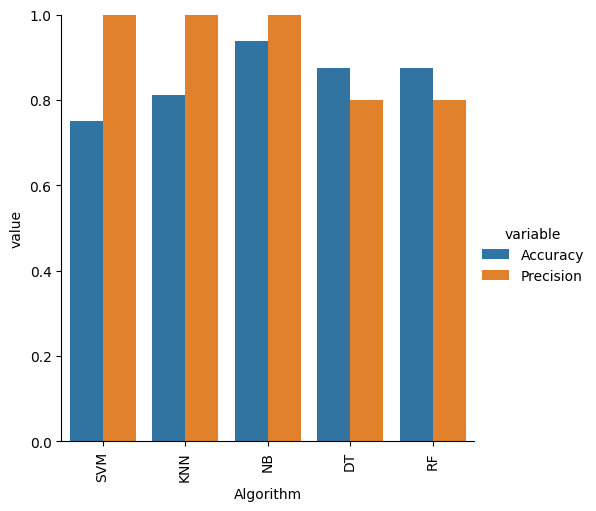

In [215]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0,1.0)
plt.xticks(rotation='vertical')
plt.show()

# CV

In [216]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision 

In [217]:
from sklearn.metrics import recall_score, f1_score

print("Count Vectorizer")
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision =  train_classifier(clf, X2_train,y2_train,X2_test,y2_test)
    y_pred = clf.predict(X2_test)
    current_recall = recall_score(y2_test, y_pred)
    current_f1 = f1_score(y2_test, y_pred)
    
    print("For", name)
    print("Accuracy -", format(current_accuracy, ".4f"))
    print("Precision -", format(current_precision, ".4f"))
    print("Recall -", format(current_recall, ".4f"))
    print("F1-Score -", format(current_f1, ".4f"))
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)


Count Vectorizer
For SVM
Accuracy - 0.6250
Precision - 0.5833
Recall - 0.8750
F1-Score - 0.7000
For KNN
Accuracy - 0.5000
Precision - 0.5000
Recall - 0.1250
F1-Score - 0.2000
For NB
Accuracy - 0.8750
Precision - 1.0000
Recall - 0.7500
F1-Score - 0.8571
For DT
Accuracy - 0.8125
Precision - 0.7778
Recall - 0.8750
F1-Score - 0.8235
For RF
Accuracy - 0.7500
Precision - 0.7000
Recall - 0.8750
F1-Score - 0.7778


In [218]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores }).sort_values('Precision',ascending=False)
performance_df

Algorithm  Accuracy  Precision
2        NB    0.8750   1.000000
3        DT    0.8125   0.777778
4        RF    0.7500   0.700000
0       SVM    0.6250   0.583333
1       KNN    0.5000   0.500000

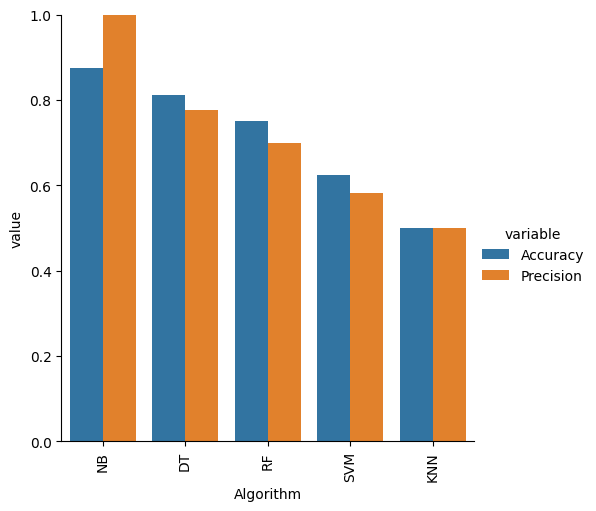

In [219]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0,1.0)
plt.xticks(rotation='vertical')
plt.show()

#  Hybrid Model Building

In [220]:
NORM_voting = VotingClassifier(estimators=[('Naive Bayes', nb), ('KNN ', knn),('DT', dt)],voting='soft')

In [221]:

NORM_voting.fit(X1_train,y1_train)

VotingClassifier(estimators=[('Naive Bayes', GaussianNB()),
                             ('KNN ', KNeighborsClassifier()),
                             ('DT', DecisionTreeClassifier())],
                 voting='soft')

Accuracy score of NB+KNN+DT  0.875
Precision score of NB+KNN+DT  1.0
recall score of NB+KNN+DT   0.75
F1-score score of NB+KNN+DT  0.8571428571428571
Classification Report               precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

ROC AUC SCORE of Hybrid Model is  0.875


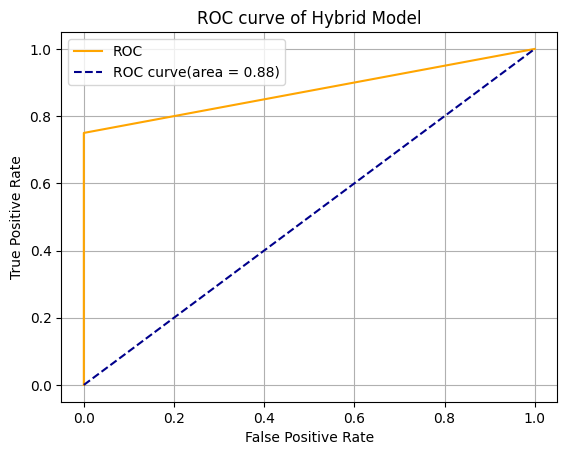

In [222]:
y_predNorm = NORM_voting.predict(X1_test)
print("Accuracy score of NB+KNN+DT ",accuracy_score(y1_test,y_predNorm))
print("Precision score of NB+KNN+DT ",precision_score(y1_test,y_predNorm))
print("recall score of NB+KNN+DT  " , recall_score(y1_test,y_predNorm))
print("F1-score score of NB+KNN+DT " , f1_score(y1_test,y_predNorm))
print('Classification Report' , classification_report(y1_test,y_predNorm))
auc = roc_auc_score (y1_test,y_predNorm)
print("ROC AUC SCORE of Hybrid Model is ", auc)
fpr ,tpr , thresholds = roc_curve(y1_test,y_predNorm)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--',label='ROC curve(area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Hybrid Model')
plt.legend()
plt.grid()
plt.show()

# DT Tuning

In [223]:
from sklearn.model_selection import GridSearchCV
# List the hyperparameters that we want to tune
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [None, 1, 3, 5, 8, 10]

# Make it into a dictionary
params_DT = {'max_depth': max_depth, 'criterion': criterion , 'splitter': splitter}

# Use Grid Search
gs_DT = GridSearchCV(estimator = dt, param_grid = params_DT, cv = 10)

# Fit the model into the X_gender and y_gender
gs_DT.fit(X1_train, y1_train)

# Print the value of best parameters
print ('Best Parameters: ', gs_DT.best_params_, '\n')

# Perform the classifier with the best parameters
tuned_dt = DecisionTreeClassifier(**gs_DT.best_params_)
tuned_dt.fit(X1_train, y1_train)
y_predtuned_dt = tuned_dt.predict(X1_test)
# Print evaluation metrics
print('Tuned DT precision:', metrics.precision_score(y1_test, y_predtuned_dt))
print('Tuned DT accuracy :', metrics.accuracy_score(y1_test, y_predtuned_dt))
print('Tuned DT Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test,y_predtuned_dt)))

Best Parameters:  {'criterion': 'entropy', 'max_depth': None, 'splitter': 'random'} 

Tuned DT precision: 1.0
Tuned DT accuracy : 0.875
Tuned DT Root Mean Squared Error: 0.3535533905932738


# KNN Tuning

In [224]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn = KNeighborsClassifier()

#Use GridSearch
tuned_knn= GridSearchCV(knn, hyperparameters, cv=10)

#Fit the model
tuned_knn.fit(X1_train, y1_train)

#Print The value of best Hyperparameters
print('Best Parameters: ',tuned_knn.best_params_, '\n')

# Create a new KNN model with the best hyperparameters
tuned_knn = KNeighborsClassifier(**tuned_knn.best_params_)
# Fit the model
tuned_knn.fit(X1_train, y1_train)
# Make predictions on the test data
y_predtuned_knn= tuned_knn.predict(X1_test)

# Print evaluation metrics
print('Tuned KNN precision:', metrics.precision_score(y1_test, y_predtuned_knn))
print('Tuned KNN accuracy :', metrics.accuracy_score(y1_test, y_predtuned_knn))
print('Tuned KNN Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test, y_predtuned_knn)) )

Best Parameters:  {'leaf_size': 1, 'n_neighbors': 17, 'p': 2} 

Tuned KNN precision: 1.0
Tuned KNN accuracy : 0.8125
Tuned KNN Root Mean Squared Error: 0.4330127018922193


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# NB Tuning

In [225]:
# Create a GNB classifier
nb = GaussianNB()
# Define the parameter grid for tuning
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X1_train, y1_train)

# Get the best hyperparameters
best_var_smoothing = grid_search.best_params_['var_smoothing']
print("Best Hyperparameters:", best_var_smoothing)

# Create a new Naive Bayes model with the best hyperparameters
tuned_nb = GaussianNB(var_smoothing=best_var_smoothing)

# Train the tuned model on the training data
tuned_nb.fit(X1_train, y1_train)

# Make predictions on the test data
y_pred_tuned_nb = tuned_nb.predict(X1_test)

print('Tuned NB precision:', metrics.precision_score(y1_test, y_pred_tuned_nb))
print('Tuned NB accuracy:', metrics.accuracy_score(y1_test, y_pred_tuned_nb))
print('Tuned NB Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test, y_pred_tuned_nb)))

Best Hyperparameters: 1e-09
Tuned NB precision: 1.0
Tuned NB accuracy: 0.9375
Tuned NB Root Mean Squared Error: 0.25


# Hybrid Tuned Model Building
## Tuned DT + Tuned KNN + Tuned NB 

In [226]:
# Voting Classifier
tuned_dt = DecisionTreeClassifier(splitter = 'random', max_depth = 10, criterion = 'gini')
tuned_knn= KNeighborsClassifier(leaf_size = 1 ,n_neighbors=3,p=2)
tuned_nb = GaussianNB(var_smoothing=1e-09 )


KNN = Best Parameters:  {'leaf_size': 1, 'n_neighbors': 3, 'p': 2} 
DT = Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'} 
NB = Best Hyperparameters: 1e-09

In [227]:
Tuned_voting = VotingClassifier(estimators=[('Tuned NB', tuned_nb), ('Tuned KNN ', tuned_knn),('Tuned DT', tuned_dt)],voting='soft')

In [228]:
Tuned_voting.fit(X1_train,y1_train)

VotingClassifier(estimators=[('Tuned NB', GaussianNB()),
                             ('Tuned KNN ',
                              KNeighborsClassifier(leaf_size=1, n_neighbors=3)),
                             ('Tuned DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     splitter='random'))],
                 voting='soft')

Accuracy score of Tuned hybrid  0.9375
Precision score of Tuned hybrid 1.0
recall score of Tuned hybrid   0.875
F1-score score of Tuned hybrid  0.9333333333333333
Classification Report               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

ROC AUC SCORE of Tuned Hybrid Model is  0.9375


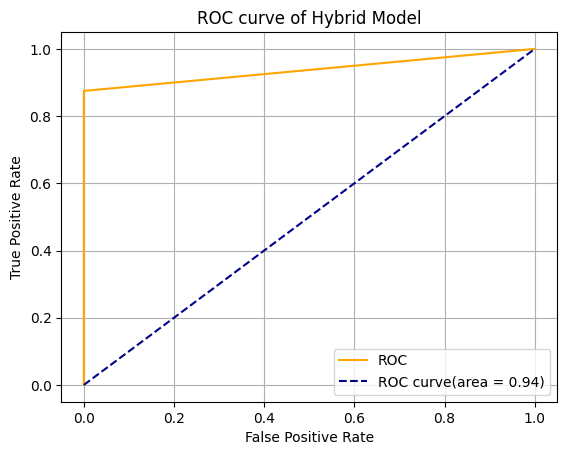

In [229]:
y_predTuned_hybrid = Tuned_voting.predict(X1_test)
print("Accuracy score of Tuned hybrid ",accuracy_score(y1_test,y_predTuned_hybrid))
print("Precision score of Tuned hybrid",precision_score(y1_test,y_predTuned_hybrid))
print("recall score of Tuned hybrid  " , recall_score(y1_test,y_predTuned_hybrid))
print("F1-score score of Tuned hybrid " , f1_score(y1_test,y_predTuned_hybrid))
print('Classification Report' , classification_report(y1_test,y_predTuned_hybrid))
auc = roc_auc_score (y1_test,y_predTuned_hybrid)
print("ROC AUC SCORE of Tuned Hybrid Model is ", auc)
fpr ,tpr , thresholds = roc_curve(y1_test,y_predTuned_hybrid)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--',label='ROC curve(area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Hybrid Model')
plt.legend()
plt.grid()
plt.show()

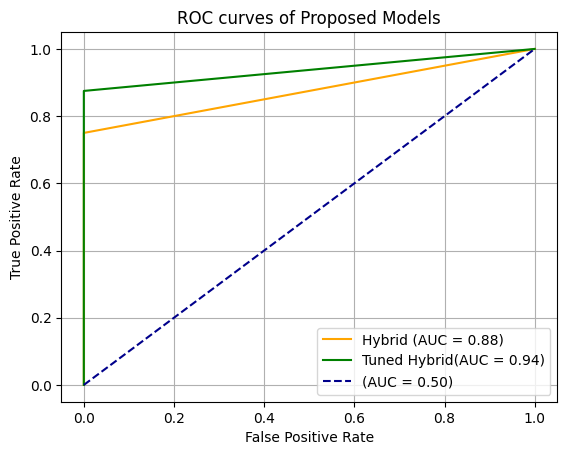

In [230]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate ROC AUC score for tuned NB
auc = roc_auc_score (y1_test,y_predNorm)
fpr, tpr, thresholds =  roc_curve(y1_test,y_predNorm)

# Calculate ROC AUC score for hybrid
auc_hybrid = roc_auc_score(y1_test, y_predTuned_hybrid)
fpr_hybrid, tpr_hybrid, thresholds_hybrid = roc_curve(y1_test, y_predTuned_hybrid)

# Plot ROC curves
plt.plot(fpr, tpr, color='orange', label='Hybrid (AUC = %0.2f)' % auc)

plt.plot(fpr_hybrid, tpr_hybrid, color='green', label='Tuned Hybrid(AUC = %0.2f)' % auc_hybrid)

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='(AUC = 0.50)')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Models')
plt.legend()
plt.grid()
plt.show()

# Website

In [232]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(Tuned_voting,open('hybridTunedModel.pkl','wb'))
